Tune hyperparameters for the following models:

- Logistic Regression
- LightGBM
- XGBoost
- Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.model_selection import  RandomizedSearchCV, GridSearchCV, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

In [2]:
# load processed train and validation data
train = pd.read_csv('../data/train_data_processed.csv')
valid = pd.read_csv('../data/valid_data_processed.csv')

In [3]:
# create X and y

X_train = train.drop(columns=['y'])
y_train = train['y']

X_valid = valid.drop(columns=['y'])
y_valid = valid['y']

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(28824, 62)
(28824,)
(6176, 62)
(6176,)


##  feature scaling

In [5]:
scaler = StandardScaler()

# fit on training data
scaler.fit(X_train)

# transform on train and valid
X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)

## Hyperparameter Tuning

## 1. Logistic Regression

In [6]:
parameters = {
    'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

# define the model
lr = LogisticRegression(random_state=2021, max_iter=200, class_weight='balanced')
cv_lr = GridSearchCV(lr, parameters, cv=5)

# run the random search cv on the train set to find the best parameters
%time cv_lr.fit(X_train_std, y_train)

CPU times: user 1min 18s, sys: 1.48 s, total: 1min 19s
Wall time: 25.6 s


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', max_iter=200,
                                          random_state=2021),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']})

In [7]:
print('The best parameters are: \n', cv_lr.best_params_)

The best parameters are: 
 {'C': 100, 'solver': 'newton-cg'}


In [8]:
# fitting with best parameters from the above search

lr_model = LogisticRegression(
    random_state=2021, 
    max_iter=200,
    class_weight='balanced',
    C=0.1,  # best_params_ gives 100 but manual experimentation with this value was better
    solver='newton-cg') 

# fit the model
lr_model.fit(X_train_std, y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=200,
                   random_state=2021, solver='newton-cg')

In [9]:
# predictions  
y_predict_train = lr_model.predict_proba(X_train_std)
y_predict_valid = lr_model.predict_proba(X_valid_std)

# AUC scores
train_score_lr = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_lr = roc_auc_score(y_valid, y_predict_valid[:,1])
print("Training ROC-AUC score of Logistic Regression model: ", train_score_lr)
print("Validation ROC-AUC score of Logistic Regression model: ", valid_score_lr)

Training ROC-AUC score of Logistic Regression model:  0.8015866888060914
Validation ROC-AUC score of Logistic Regression model:  0.7912948885805665


In [10]:
# # visualize the curve -- simple plot
# metrics.plot_roc_curve(lr_model, X_valid_std, y_valid)  
# plt.show() 

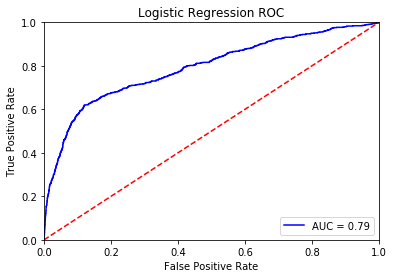

In [11]:
# more customized plot -- source: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

# calculate the fpr and tpr for all thresholds of the classification
probs = lr_model.predict_proba(X_valid_std)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_valid, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot

plt.title('Logistic Regression ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 2. LightGBM

In [12]:
# random search

parameters = {
    'num_leaves': [x for x in range(4,50, 3)],
    'max_depth':[x for x in range(-1,51, 3)],
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1, 0.3],
    'n_estimators': [x for x in range(100,1001, 100)],
}

# define the model
lgbm = lgb.LGBMClassifier(random_state=2021, objective='binary')
# cv_lgbm = GridSearchCV(lgbm, parameters, cv=5)
cv_lgbm = RandomizedSearchCV(lgbm, parameters, cv=5)

# run the random search cv on the train set to find the best parameters
%time cv_lgbm.fit(X_train_std, y_train)

CPU times: user 4min 50s, sys: 10.7 s, total: 5min 1s
Wall time: 41.3 s


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(objective='binary',
                                            random_state=2021),
                   param_distributions={'learning_rate': [0.01, 0.015, 0.025,
                                                          0.05, 0.1, 0.3],
                                        'max_depth': [-1, 2, 5, 8, 11, 14, 17,
                                                      20, 23, 26, 29, 32, 35,
                                                      38, 41, 44, 47, 50],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'num_leaves': [4, 7, 10, 13, 16, 19, 22,
                                                       25, 28, 31, 34, 37, 40,
                                                       43, 46, 49]})

In [13]:
print('The best parameters are: \n', cv_lgbm.best_params_)

The best parameters are: 
 {'num_leaves': 10, 'n_estimators': 200, 'max_depth': 47, 'learning_rate': 0.05}


In [14]:
# fitting with best parameters from the above search

lgb_model = lgb.LGBMClassifier(
    random_state=2021, 
    objective='binary',
    num_leaves=10,
    max_depth=47,
    learning_rate=0.05,
    n_estimators=200) 

# fit the model
lgb_model.fit(X_train_std, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=47, n_estimators=200,
               num_leaves=10, objective='binary', random_state=2021)

In [15]:
# predictions
y_predict_train = lgb_model.predict_proba(X_train_std)
y_predict_valid = lgb_model.predict_proba(X_valid_std)

# AUC scores
train_score_lgb = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_lgb = roc_auc_score(y_valid, y_predict_valid[:,1])
print("Training ROC-AUC score of LightGBM model: ", train_score_lgb)
print("Validation ROC-AUC score of LightGBM model: ", valid_score_lgb)

Training ROC-AUC score of LightGBM model:  0.839837717512548
Validation ROC-AUC score of LightGBM model:  0.8017222623909743


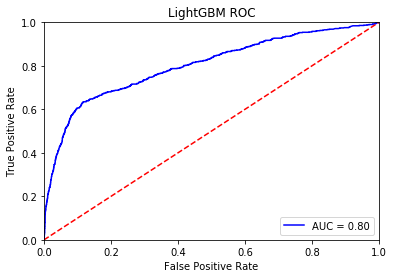

In [16]:
# visualize the curve

# calculate the fpr and tpr for all thresholds of the classification
probs = lgb_model.predict_proba(X_valid_std)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_valid, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot

plt.title('LightGBM ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3. XGBoost

In [17]:
parameters = {
    'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1, 0.3],
    'n_estimators': [x for x in range(100,1001, 100)],
    'max_depth': [3, 4, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
}

# define the model
xgbc = xgb.XGBClassifier(random_state = 2021, verbosity=0)
cv_xgb = RandomizedSearchCV(xgbc, parameters, cv=5)

# run the random search cv on the train set to find the best parameters
%time cv_xgb.fit(X_train_std, y_train)

/Users/rachel/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 51min 54s, sys: 1min 11s, total: 53min 6s
Wall time: 7min 52s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [18]:
print('The best parameters are: \n', cv_xgb.best_params_)

The best parameters are: 
 {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.025, 'colsample_bytree': 0.3}


In [19]:
# fitting with best parameters from the above search

xgb_model = xgb.XGBClassifier(
    random_state=2021, 
    learning_rate=0.025,
    n_estimators=1000,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.3
) 

# fit the model
xgb_model.fit(X_train_std, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.025, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [20]:
# predictions
y_predict_train = xgb_model.predict_proba(X_train_std)
y_predict_valid = xgb_model.predict_proba(X_valid_std)

# AUC scores
train_score_xgb = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_xgb = roc_auc_score(y_valid, y_predict_valid[:,1])
print("Training ROC-AUC score of XGBoost model: ", train_score_xgb)
print("Validation ROC-AUC score of XGBoost model: ", valid_score_xgb)

Training ROC-AUC score of XGBoost model:  0.8472161199426701
Validation ROC-AUC score of XGBoost model:  0.8024911574463096


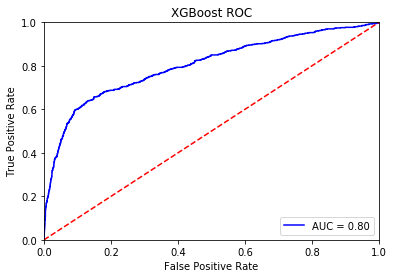

In [21]:
# visualize the curve

# calculate the fpr and tpr for all thresholds of the classification
probs = xgb_model.predict_proba(X_valid_std)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_valid, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot

plt.title('XGBoost ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest

In [22]:
parameters = {
    'max_features': [x for x in range(15,(len(X_train.columns)+1), 50)],
    'n_estimators': [50, 100, 250, 500, 750, 1000], 
    'max_depth': [10, 25, 50, 75, 100] + [None]
}

# define the model
rf = RandomForestClassifier(random_state=2021)
cv_rf = RandomizedSearchCV(rf, parameters, cv=5)

# run the random search cv on the train set to find the best parameters
%time cv_rf.fit(X_train_std, y_train)

CPU times: user 8min 40s, sys: 7.63 s, total: 8min 47s
Wall time: 8min 55s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2021),
                   param_distributions={'max_depth': [10, 25, 50, 75, 100,
                                                      None],
                                        'max_features': [15],
                                        'n_estimators': [50, 100, 250, 500, 750,
                                                         1000]})

In [23]:
print('The best parameters are: \n', cv_rf.best_params_)

The best parameters are: 
 {'n_estimators': 500, 'max_features': 15, 'max_depth': 10}


In [24]:
# fitting with best parameters from the above search

rf_model = RandomForestClassifier(
    random_state=2021, 
    n_estimators = 500, 
    max_features = 15,
    max_depth = 10
) 

# fit the model
rf_model.fit(X_train_std, y_train)

RandomForestClassifier(max_depth=10, max_features=15, n_estimators=500,
                       random_state=2021)

In [25]:
# predictions
y_predict_train = rf_model.predict_proba(X_train_std)
y_predict_valid = rf_model.predict_proba(X_valid_std)

# AUC scores
train_score_rf = roc_auc_score(y_train, y_predict_train[:,1])
valid_score_rf = roc_auc_score(y_valid, y_predict_valid[:,1])
print("Training ROC-AUC score of Random Forest model: ", train_score_rf)
print("Validation ROC-AUC score of Random Forest model: ", valid_score_rf)

Training ROC-AUC score of Random Forest model:  0.8752111136403355
Validation ROC-AUC score of Random Forest model:  0.8051141552511416


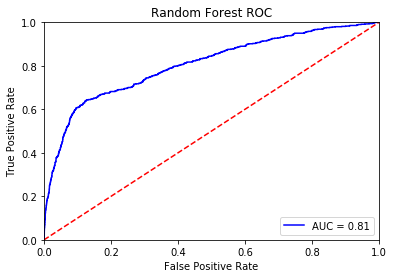

In [26]:
# visualize the curve

# calculate the fpr and tpr for all thresholds of the classification
probs = rf_model.predict_proba(X_valid_std)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_valid, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot

plt.title('Random Forest ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## summary & results

In [27]:
summary = {
    'model':['Logistic Regression', 'LightGBM', 'XGBoost', 'Random Forest'],
    'Train ROC-AUC score':[train_score_lr, train_score_lgb, train_score_xgb, train_score_rf],
    'Validation ROC-AUC score':[valid_score_lr, valid_score_lgb, valid_score_xgb, valid_score_rf]
}

pd.DataFrame(summary)

,model,Train ROC-AUC score,Validation ROC-AUC score
0,Logistic Regression,0.801587,0.791295
1,LightGBM,0.839838,0.801722
2,XGBoost,0.847216,0.802491
3,Random Forest,0.875211,0.805114


## results:

- The Logistic Regression model's validation score improved a small amount from the initial model with default parameters, but overfit more here.
- The LightGBM model's validation score decreased a small amount, but is overfitting less.
- The XGBoost model's validation score improved a bit, and is overfitting less. I might argue that this is the best model of this group, given that it has the 3rd highest score but overfits less than the Random Forest model.
- The Random Forest model validation score saw the largest improvement from tuning, but this model is still overfitting more than any other in this set. This model achieved the best validation score in this set.
